Google Drive Authentication
---

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/My Drive/IIC/

Mounted at /gdrive
/gdrive/My Drive/DrRabiee-Project


Importing/Installing the Necessary Libraries
---

In [ ]:
!pip install shap

     |████████████████████████████████| 358kB 5.2MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491621 sha256=53d91340f878049bad98a1e577caa802c6e3614be5c25cd0c5ef416170d52851
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image
import cv2
from skimage.color import gray2rgb
from tensorflow import keras
import matplotlib.pylab as pl
import shap
from skimage.segmentation import slic
from matplotlib.colors import LinearSegmentedColormap
import random
import bottleneck as bn
from sklearn.metrics import accuracy_score

Loading the Model
---

In [ ]:
model = load_model('models/mnist.h5')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

Data Preparation
---

In [ ]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 3)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 3)
x_train = gray2rgb(x_train.reshape(x_train.shape[0],28,28))
x_test = gray2rgb(x_test.reshape(x_test.shape[0],28,28))

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 3)
60000 train samples
10000 test samples


Classify Custom Images
---

In [ ]:
def prepare_img(filepath):
    img_name = filepath.split('/')[-1]
    im = np.array(Image.open(filepath).convert('L'))
    im = cv2.resize(im, dsize=(28, 28), interpolation=cv2.INTER_CUBIC)
    im = gray2rgb(im.reshape(28,28))
    return im

In [ ]:
np_img = prepare_img('7.png')

In [ ]:
np_img.shape

(28, 28, 3)

In [ ]:
def classify_img(model, img):
    img = img.reshape((1,img.shape[0],img.shape[1],3))
    img = img.astype("float32") / 255
    pred = model(img)[0]
    class_idx = np.argmax(pred)
    return class_idx

In [ ]:
classify_img(model, np_img)

7

Image Desctruction: Adding Pepper Noise to the Images such that only 20 percent of the most important pixels of each one remains.
---

In [ ]:
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

In [ ]:
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out

In [ ]:
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
cm = LinearSegmentedColormap.from_list("shap", colors)

In [ ]:
feature_names = {'0':['n1','0'], '1':['n2','1'], '2':['n3','2'], '3':['n4','3'], '4':['n5','4'], '5':['n6','5'], '6':['n7','6'], '7':['n8','7'], '8':['n9','8'], '9':['n10','9']}

In [ ]:
def cifar_to_pil(img):
    img = img*255
    PIL_image = Image.fromarray(np.uint8(img)).convert('RGB')
    return PIL_image

In [ ]:
def get_shap_values(img_orig, model, num_segments=50):
    def f(z):
        return model.predict(mask_image(z, segments_slic, img_orig, 255))

    img = cifar_to_pil(img_orig)
    segments_slic = slic(img, n_segments=num_segments, compactness=30, sigma=3)
    explainer = shap.KernelExplainer(f, np.zeros((1,num_segments)))
    shap_values = explainer.shap_values(np.ones((1,num_segments)), nsamples=1000)
    preds = model.predict(np.expand_dims(img_orig.copy(), axis=0))
    top_preds = np.argsort(-preds)
    return img, segments_slic, shap_values, top_preds

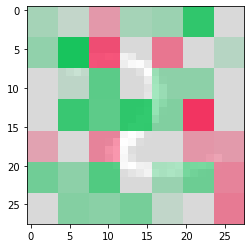

In [ ]:
img_orig = x_test[2500]
img, segments_slic, shap_values, top_preds = get_shap_values(img_orig, model)
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
num_top_pred = 0
m = fill_segmentation(shap_values[top_preds[0][num_top_pred]][0], segments_slic)
plt.imshow(img.convert('LA'), alpha=0.15)
plt.imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)

In [ ]:
def get_heatmap(input_img, model):
    img_orig = input_img
    img, segments_slic, shap_values, top_preds = get_shap_values(img_orig, model)
    max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
    num_top_pred = 0
    heatmap = fill_segmentation(shap_values[top_preds[0][num_top_pred]][0], segments_slic)
    return heatmap

In [ ]:
# the following function gets the top n elements (in terms of magnitude) from a numpy array
def top_n_indexes(arr, n):
    idx = bn.argpartition(arr, arr.size-n, axis=None)[-n:]
    width = arr.shape[1]
    return [divmod(i, width) for i in idx]

In [ ]:
# given a list of tuples (pixel indices), this function generates a list of other pixels
def get_other_pixels(idx_list):
    idx_list = set(idx_list)
    other_pixels = []
    for i in range(28):
        for j in range(28):
            if (i,j) not in idx_list:
                other_pixels.append((i,j))
    return other_pixels

In [ ]:
# given an image and a heatmap showing the importance of each pixels, this function destructs the image such that only a specified percentage of
# the most important pixels remains, and the other ones get replaced by salt and pepper noise
def destruct_image(img, heatmap, percentage=0.2):
    result = img.copy()
    idx_list = top_n_indexes(heatmap, int(percentage*(28*28)))
    idx_list.sort(key = lambda tup: tup[0])
    other_pixels = get_other_pixels(idx_list)
    for idx in other_pixels:
        # random_val = random.sample([0,1], 1)[0]
        random_val = 0
        result[idx[0],idx[1],0] = random_val
        result[idx[0],idx[1],1] = random_val
        result[idx[0],idx[1],2] = random_val
    return result

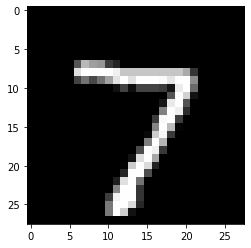

In [ ]:
plt.imshow(x_test[0])

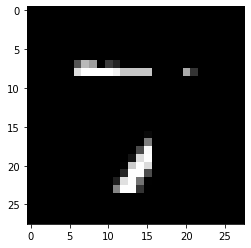

In [ ]:
plt.imshow(destruct_image(x_test[0], get_heatmap(x_test[0], model), 0.2))

In [ ]:
num_samples = 1000

In [ ]:
new_x_test = []
for curr_img in x_test[:num_samples]:
    curr_heatmap = get_heatmap(curr_img, model)
    new_img = destruct_image(curr_img, curr_heatmap, 0.2)
    new_x_test.append(new_img)
new_x_test = np.array(new_x_test)

In [ ]:
new_predictions = model.predict(new_x_test)

In [ ]:
new_predictions = list(np.argmax(new_predictions, axis=1))
true_labels = list(np.argmax(y_test[:num_samples], axis=1))

In [ ]:
accuracy_score(true_labels, new_predictions)

0.232